<h1>Sommaire<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Initialization-of-Spark-Session" data-toc-modified-id="Initialization-of-Spark-Session-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initialization of Spark Session</a></span></li><li><span><a href="#Features-extraction-from-data-on-S3-bucket" data-toc-modified-id="Features-extraction-from-data-on-S3-bucket-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Features extraction from data on S3 bucket</a></span><ul class="toc-item"><li><span><a href="#Reading-data" data-toc-modified-id="Reading-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Reading data</a></span></li><li><span><a href="#Preparing-the-model" data-toc-modified-id="Preparing-the-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Preparing the model</a></span></li><li><span><a href="#Define-image-loading-and-featurization-logic-in-a-Pandas-UDF" data-toc-modified-id="Define-image-loading-and-featurization-logic-in-a-Pandas-UDF-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Define image loading and featurization logic in a Pandas UDF</a></span></li><li><span><a href="#Apply-featurization-to-the-DataFrame-of-images" data-toc-modified-id="Apply-featurization-to-the-DataFrame-of-images-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Apply featurization to the DataFrame of images</a></span></li></ul></li><li><span><a href="#Standardisation-of-features" data-toc-modified-id="Standardisation-of-features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Standardisation of features</a></span></li><li><span><a href="#Dimension-reduction-by-PCA" data-toc-modified-id="Dimension-reduction-by-PCA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Dimension reduction by PCA</a></span></li><li><span><a href="#Saving-features-in-project-bucket-on-S3" data-toc-modified-id="Saving-features-in-project-bucket-on-S3-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Saving features in project bucket on S3</a></span></li></ul></div>

## Imports

In [1]:
import io
import os 
import warnings
import sys
import boto3
import findspark
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from PIL import Image
# import tensorflow

from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark import Row
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.sql import SparkSession
from pyspark.sql.functions import (split, 
                                   size,
                                   col,
                                   input_file_name,
                                   udf,
                                   pandas_udf,
                                   PandasUDFType
                                  )
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

findspark.init()
findspark.find()

2022-12-13 17:22:07.641547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 17:22:08.510620: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 17:22:08.510659: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 17:22:10.765371: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

'/home/ec2-user/miniconda3/lib/python3.9/site-packages/pyspark'

In [8]:
os.environ['PYSPARK_PYTHON'] = sys.executable
print('PYSPARK_PYTHON ', os.environ['PYSPARK_PYTHON'])

PYSPARK_PYTHON  /home/ec2-user/miniconda3/bin/python


## Initialization of Spark Session

In [2]:
# Spark configuration
conf = SparkConf()
conf.set('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.2')
conf.set('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')
conf.setMaster("local").setAppName("P8")
conf.set('spark.hadoop.fs.s3a.access.key', ACCESS_KEY)
conf.set('spark.hadoop.fs.s3a.secret.key', SECRET_KEY)
conf.set('spark.port.maxRetries', 100)

In [3]:
sc = SparkContext(conf=conf)

:: loading settings :: url = jar:file:/home/ec2-user/miniconda3/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0d9a7899-9983-421d-a493-a1196d1030af;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.1026 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 323ms :: artifacts dl 16ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.1026 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.2 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	--------------------------

22/12/13 17:22:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
spark = SparkSession.builder.master("local[*]").config(conf=conf).getOrCreate()

In [5]:
spark

## Features extraction from data on S3 bucket

### Reading data

In [7]:
s3_boto3 = boto3.resource('s3')
bucket = s3_boto3.Bucket('bucketprojet8inl')

In [8]:
image_df = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg")\
                .option("recursiveFileLookup", "true")\
                .load("s3a://bucketprojet8inl/TrainingSample/*")

# s3a://(bucket name)/(path)/*

22/12/13 17:22:43 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [9]:
collect = image_df.select('content').collect()
image_df = image_df.drop("modificationTime", "length")
image_df = image_df.withColumn('label', split(image_df.path, '/').getItem(4))
image_df.show(truncate=20)

+--------------------+--------------------+--------------+
|                path|             content|         label|
+--------------------+--------------------+--------------+
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|    Clementine|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|    Clementine|
|s3a://bucketproje...|[FF D8 FF E0 00 1...|    Strawberr

In [10]:
image_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)



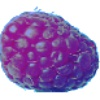

In [30]:
# affichage d'une image 

first_img = collect[1][0]
image_1 =Image.open(io.BytesIO(first_img))
image_1.show()

### Preparing the model

This part of the project was prepared using this tutorial: <br>
https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html

In [11]:
model = ResNet50(include_top=False)
model.summary()  # verify that the top layer is removed


2022-12-13 17:23:06.875554: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-13 17:23:06.875596: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-13 17:23:06.875621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-38-162.eu-west-3.compute.internal): /proc/driver/nvidia/version does not exist
2022-12-13 17:23:06.876636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [12]:
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model


### Define image loading and featurization logic in a Pandas UDF

In [13]:

def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)


def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
  # For some layers, output features will be multi-dimensional tensors.
  # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)



The following method is a Scalar Iterator pandas UDF wrapping our featurization function.
The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
 
With Scalar Iterator pandas UDFs, we can load the model once and then re-use it for multiple data batches.  This amortizes the overhead of loading big models.

In [14]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    """
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)
        
        

/home/ec2-user/miniconda3/lib/python3.9/site-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### Apply featurization to the DataFrame of images

In [15]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [16]:
# création d'UDF qui transforme chaque ligne vers un vecteur
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

In [17]:
features_df = image_df.repartition(16).select(featurize_udf("content").alias("features"))

In [18]:
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.

# appliquer "featurize_udf" sur tout le dataframe
features_df = image_df.repartition(16).select(col('path'), featurize_udf('content').alias('features'))
# appliquer "list_to_vector_udf" sur tout le dataframe
features_df = features_df.withColumn("features_udf", list_to_vector_udf(col("features")))

In [19]:
features_df.show()

2022-12-13 17:23:43.964460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 17:23:44.103769: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 17:23:44.103812: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 17:23:44.851228: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

+--------------------+--------------------+--------------------+
|                path|            features|        features_udf|
+--------------------+--------------------+--------------------+
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.

In [20]:
# extraire nombre de features
print("le nombre de features initial est:", len(features_df.collect()[1][2]))

1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


le nombre de features initial est: 100352


## Standardisation of features

In [21]:
# standardisation des features

scaler = StandardScaler(
    inputCol="features_udf", 
    outputCol="features_scaled")

data_scaled = scaler.fit(features_df).transform(features_df)

1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


In [22]:
data_scaled.show()

1/1 [==============================] - 1s 1s/step====>              (3 + 1) / 4]


+--------------------+--------------------+--------------------+--------------------+
|                path|            features|        features_udf|     features_scaled|
+--------------------+--------------------+--------------------+--------------------+
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://bucketproje...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.

## Dimension reduction by PCA

In [23]:
#entrainement de l'algorithme PCA
pca = PCA(k=50, inputCol="features_scaled", outputCol="features_reduced")
model_pca = pca.fit(data_scaled)
data_final = model_pca.transform(data_scaled)

1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1621.4 KiB


1/1 [==============================] - 1s 1s/step                   (0 + 1) / 1]


22/12/13 17:28:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/13 17:28:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/12/13 17:28:12 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
22/12/13 17:28:12 WARN InstanceBuilder$NativeARPACK: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK


22/12/13 17:28:12 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step                  (0 + 1) / 16]


22/12/13 17:28:17 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/13 17:28:17 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:29:08 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 2s 2s/step=============>   (15 + 1) / 16]


22/12/13 17:30:02 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:30:02 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:31:55 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:31:55 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:32:50 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:32:50 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:34:39 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:34:39 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:36:27 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:36:27 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:37:21 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:37:21 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:40:02 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:40:02 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:40:56 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:40:56 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:41:50 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:41:51 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 2s 2s/step=============>   (15 + 1) / 16]


22/12/13 17:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 17:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 2s 2s/step                  (5 + 1) / 16]


22/12/13 17:44:17 WARN NettyRpcEnv: Ignored failure: java.util.concurrent.TimeoutException: Cannot receive any reply from ip-172-31-38-162.eu-west-3.compute.internal:40069 in 10000 milliseconds


1/1 [==============================] - 2s 2s/step                  (6 + 1) / 16]


22/12/13 17:47:47 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 185091 ms exceeds timeout 120000 ms
22/12/13 17:55:07 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1053)
	at org.apache.spark.e

2022-12-13 17:55:08.222547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 17:55:09.683369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 17:55:09.683409: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 17:55:12.320418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

22/12/13 17:55:47 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:55:47 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:56:41 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:57:35 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:57:35 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:58:28 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:58:29 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 17:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 17:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:00:18 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:00:18 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:01:13 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:01:13 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:02:08 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:02:08 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:03:02 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:03:02 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:03:57 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:03:57 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:05:45 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:05:45 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:07:32 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 18:07:32 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:12:06 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:12:06 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:13:01 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:13:01 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:16:35 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:16:35 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:17:28 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:17:29 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:18:22 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:18:22 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:20:09 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:20:09 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:21:02 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:21:03 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:21:56 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:22:50 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:23:43 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:23:43 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:24:36 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:24:37 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 3s 3s/step=============>   (15 + 1) / 16]


22/12/13 18:26:32 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:26:32 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 2s 2s/step                  (7 + 1) / 16]
2022-12-13 18:31:08.080019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 18:31:09.912386: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 18:31:09.912436: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 18:31:12.608234: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror:

22/12/13 18:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:33:46 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:33:46 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:35:46 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:35:46 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:38:45 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:38:45 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:40:43 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:40:44 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:42:43 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:42:43 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:43:42 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:43:42 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:44:41 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:44:41 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:45:40 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:45:41 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:46:40 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:46:40 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:47:40 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:47:40 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:49:38 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:49:38 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:50:38 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:50:38 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:51:37 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:51:37 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:52:37 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:52:37 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:54:35 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:55:35 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:55:36 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:56:36 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:56:36 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:57:35 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:57:35 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 18:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 18:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 19:00:36 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 19:00:36 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 19:01:35 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 19:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 5s 5s/step=============>   (15 + 1) / 16]


22/12/13 19:03:46 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:03:47 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 19:05:46 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 19:05:46 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 5s 5s/step=============>   (15 + 1) / 16]


22/12/13 19:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 19:10:39 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 19:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 5s 5s/step=============>   (15 + 1) / 16]


22/12/13 19:13:06 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:13:06 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 2s 2s/step=============>   (15 + 1) / 16]


22/12/13 19:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 5s 5s/step=============>   (15 + 1) / 16]


22/12/13 19:17:54 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 2s 2s/step=============>   (15 + 1) / 16]


22/12/13 19:20:34 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:20:34 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 5s 5s/step=============>   (15 + 1) / 16]


22/12/13 19:22:48 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 19:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 19:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 5s 5s/step=============>   (15 + 1) / 16]


22/12/13 19:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 19:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 19:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 5s 5s/step=============>   (15 + 1) / 16]


22/12/13 19:32:08 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:32:09 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]


22/12/13 19:35:16 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/12/13 19:35:16 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 5s 5s/step=============>   (15 + 1) / 16]


22/12/13 19:36:40 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:36:41 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 5s 5s/step=============>   (15 + 1) / 16]


22/12/13 19:40:05 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:40:05 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 2s 2s/step=============>   (15 + 1) / 16]


22/12/13 19:41:12 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:41:12 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


1/1 [==============================] - 5s 5s/step=============>   (15 + 1) / 16]


22/12/13 19:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB


22/12/13 19:44:42 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


La variance expliquée égale a 99% est vérifiée avec 48 composantes


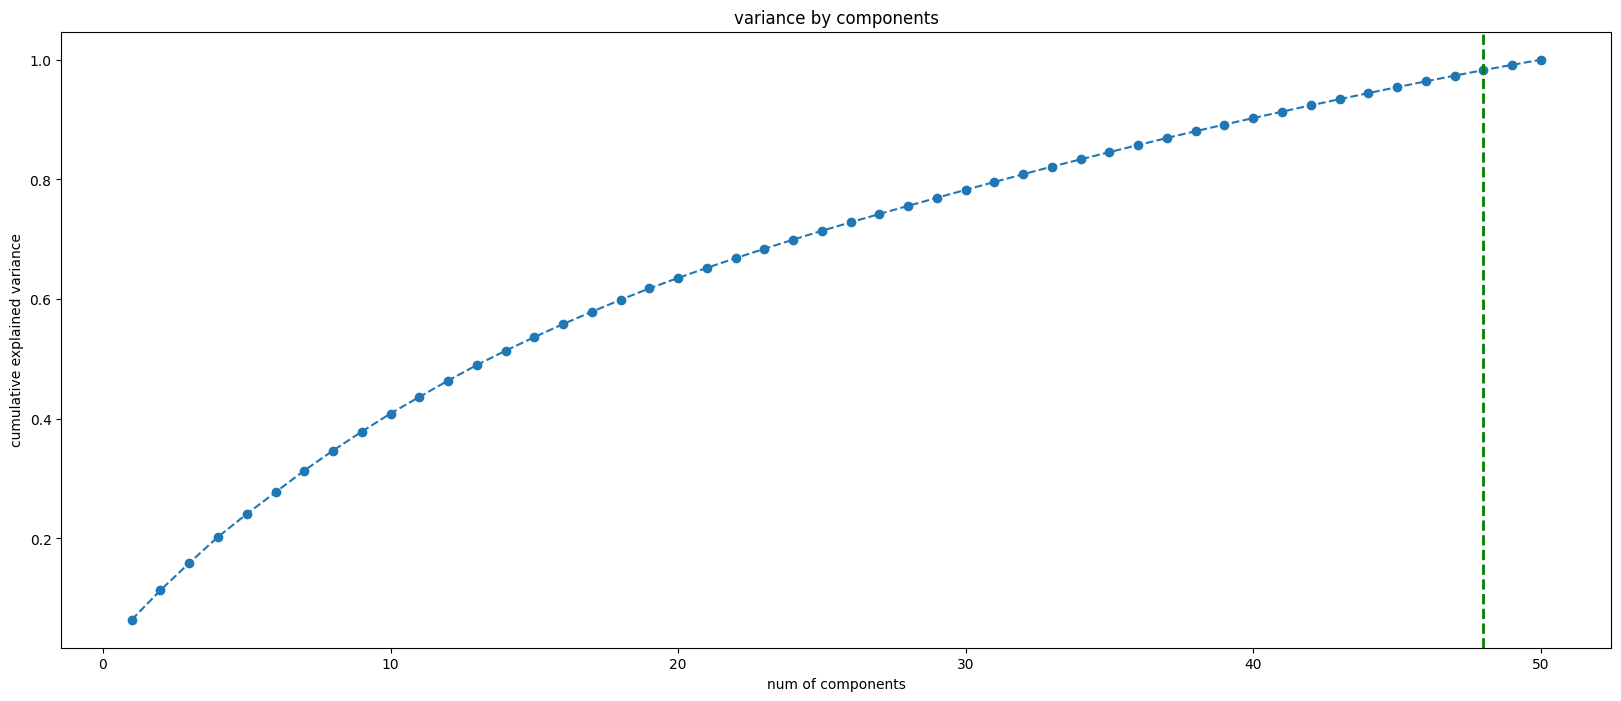

In [25]:
# Calcul de la variance expliquée cumulée par les composantes
cumValues = model_pca.explainedVariance.cumsum() # get the cumulative values

# fixer le seuil de variance expliqué minimal
seuil = 99

# afficher le graphe pour décider du nombre de composantes à considérer
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(range(1,51), cumValues, marker = 'o', linestyle='--')

X_idx = np.where(cumValues*100 >= seuil)[0]
nb_composante = X_idx[cumValues[X_idx].argmin()]
plt.axvline(x=nb_composante, linestyle="--", color="green",linewidth=2)

plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')


print(f"La variance expliquée égale a {seuil}% est vérifiée avec {nb_composante} composantes")

## Saving features in project bucket on S3

In [26]:
data_final = data_final.select(col('path'), col('features_reduced'))

In [27]:
data_final.show()

22/12/13 19:57:09 WARN DAGScheduler: Broadcasting large task binary with size 39.1 MiB


2022-12-13 19:57:10.381647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 19:57:10.916436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 19:57:10.916491: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 19:57:12.656786: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

22/12/13 19:57:20 WARN DAGScheduler: Broadcasting large task binary with size 39.1 MiB


1/1 [==============================] - 1s 1s/step


+--------------------+--------------------+
|                path|    features_reduced|
+--------------------+--------------------+
|s3a://bucketproje...|[9.20779749732080...|
|s3a://bucketproje...|[11.4867073308506...|
|s3a://bucketproje...|[11.6622179658924...|
|s3a://bucketproje...|[5.05887517096046...|
|s3a://bucketproje...|[-1.9347621400378...|
|s3a://bucketproje...|[12.3494310403914...|
|s3a://bucketproje...|[5.45463836846679...|
|s3a://bucketproje...|[0.36158904333050...|
|s3a://bucketproje...|[-9.7095086390654...|
|s3a://bucketproje...|[-0.7570134540687...|
|s3a://bucketproje...|[-7.1474715554586...|
|s3a://bucketproje...|[-13.300566498940...|
|s3a://bucketproje...|[-13.482108203287...|
|s3a://bucketproje...|[7.02347691024967...|
|s3a://bucketproje...|[4.84697899781739...|
|s3a://bucketproje...|[10.5039820846058...|
|s3a://bucketproje...|[1.01737777019760...|
|s3a://bucketproje...|[-0.9786128538489...|
|s3a://bucketproje...|[5.02905521469436...|
|s3a://bucketproje...|[-16.93511

In [28]:
data_final.write.parquet("s3a://bucketprojet8inl/extractedFeatures.parquet")

22/12/13 19:58:03 WARN DAGScheduler: Broadcasting large task binary with size 39.3 MiB


1/1 [==============================] - 1s 1s/step=============>   (15 + 1) / 16]
